In [7]:
from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
from PIL import Image
from sklearn.decomposition import KernelPCA

In [8]:
import glob
from PIL import Image
import matplotlib.image as mpimg

albacore_image_files = glob.glob('train/LAG/*.jpg')
# print(image_files)
albacore_image_list = []
size = 300, 300

for filename in albacore_image_files:
    image=Image.open(filename).resize(size).convert('LA')
    albacore_image_list.append(image)

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])



igs = np.array([rgb2gray(mpimg.imread(image)) for image in albacore_image_files])


In [10]:
train_data = igs.astype('float32')
train_data = train_data / 255
igs_pca = train_data.reshape(67, (train_data.shape[1]*train_data.shape[2]))
igs_pca.shape

(67, 921600)

In [43]:
igs.shape

(67, 720, 1280)

In [12]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 50
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfaces = pca.components_.reshape((n_components, train_data.shape[1], train_data.shape[2]))

Extracting the top 50 eigenfaces from 67 faces
CPU times: user 20.3 s, sys: 1.17 s, total: 21.5 s
Wall time: 6.26 s


In [13]:
pca.components_.shape

(50, 921600)

In [14]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [15]:
plot_explained_variance(pca)

In [16]:

n_components = 50
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, igs.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(igs_pca)

Extracting the top 50 eigenfaces from 67 faces
CPU times: user 1.94 s, sys: 183 ms, total: 2.13 s
Wall time: 764 ms


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=50,
     remove_zero_eig=False, tol=0)

In [17]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods
X = igs_pca
n_samples, n_features = igs_pca.shape
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    plt.show()

    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

<function __main__.plt_reconstruct>

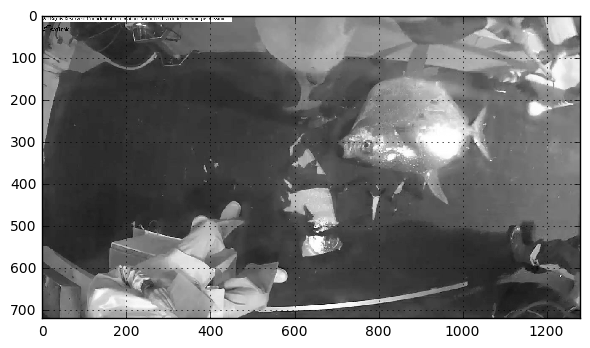

In [18]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2]))
imshow(img)
plt.grid()
plt.show()

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



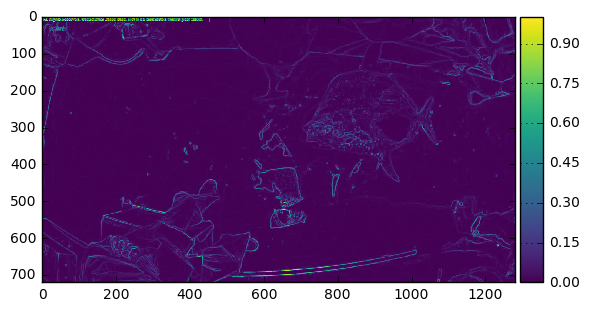

In [19]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()
plt.show()

In [20]:
gradient_mag

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00225045,  0.00531361, ...,  0.01177283,
         0.0054381 ,  0.        ],
       [ 0.        ,  0.00487083,  0.00649634, ...,  0.0149653 ,
         0.00798984,  0.        ],
       ..., 
       [ 0.        ,  0.00392157,  0.00392157, ...,  0.03804292,
         0.03743406,  0.        ],
       [ 0.        ,  0.00392157,  0.00392157, ...,  0.03106577,
         0.03059313,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

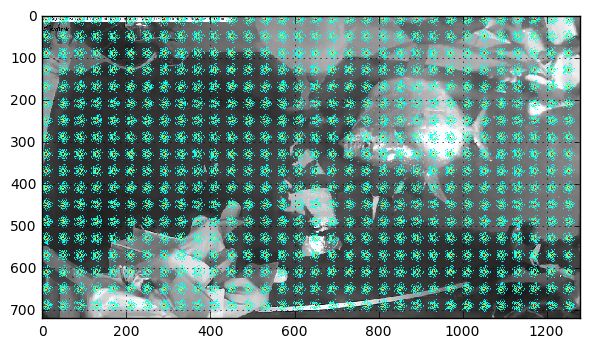

In [21]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

In [22]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(70, 126, 72)
635040


In [23]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(train_data.shape[1], train_data.shape[2]))
test_feature.shape

CPU times: user 1.23 s, sys: 403 ms, total: 1.63 s
Wall time: 1.63 s


(917280,)

In [24]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, ((train_data.shape[1], train_data.shape[2])))
gabr_feature

array([  4.36830074e-01,   3.57338339e-02,   9.48626876e-01,
         4.15438287e-01,   1.33541286e-01,   3.42843472e-03,
         9.66676354e-01,   4.75309755e-01,   2.94671476e-01,
         1.56616978e-02,   9.13932323e-01,   3.80432368e-01,
         4.39540570e-04,   1.13443957e-05,  -1.29864067e-01,
         1.38314939e+02,   4.36833978e-01,   3.57410647e-02,
         9.48931992e-01,   4.16005622e-01,   1.33728430e-01,
         3.44151794e-03,   9.76697147e-01,   4.75130359e-01,
         2.97223449e-01,   1.59728359e-02,   9.14654791e-01,
         3.74303050e-01,   7.07936852e-05,   4.23907795e-06,
         2.31432933e-02,   1.20176463e+02,   4.36830074e-01,
         3.57486904e-02,   9.49322879e-01,   4.16753627e-01,
         1.33541316e-01,   3.49455164e-03,   9.92943585e-01,
         5.62586577e-01,   2.94671506e-01,   1.58133283e-02,
         9.20467019e-01,   3.78228985e-01,   4.39540570e-04,
         2.17886609e-05,  -2.65591383e-01,   1.27425803e+02,
         4.36833978e-01,

In [25]:
0.019 * len(X) # approximate how long it may run

1.273

In [26]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (train_data.shape[1], train_data.shape[2]))
print(daisy_features.shape)

CPU times: user 1min 31s, sys: 29.7 s, total: 2min 1s
Wall time: 2min 2s
(67, 917280)


In [27]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 409 ms, sys: 15.2 ms, total: 425 ms
Wall time: 164 ms


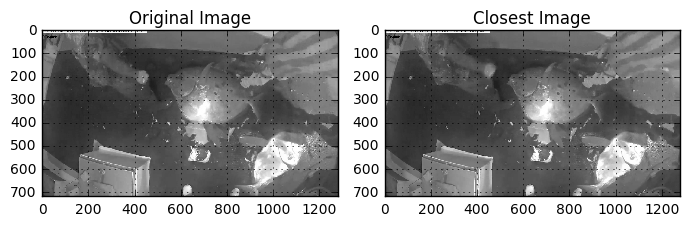

In [28]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
plt.title("Closest Image")
plt.grid()
plt.show()

In [29]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, ((train_data.shape[1], train_data.shape[2])))
print(gabor_stats.shape)

CPU times: user 3min 12s, sys: 9.13 s, total: 3min 22s
Wall time: 3min 23s
(67, 64)


In [30]:
from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Next Closest Image ")
    plt.grid()
    plt.show()


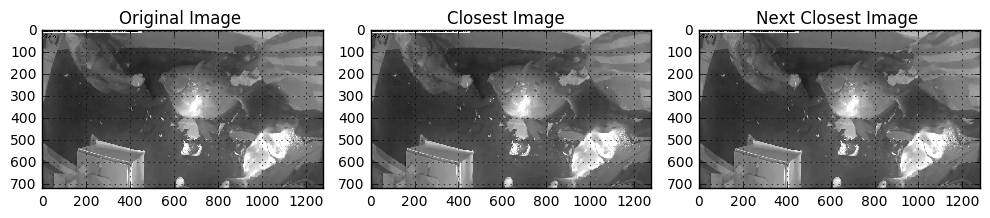

In [31]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

In [42]:
igs[0]

array([[ 253.843,  252.772,  254.288, ...,   83.205,   81.977,   80.977],
       [ 254.473,  253.772,  255.   , ...,   83.205,   82.906,   83.134],
       [ 253.206,  253.288,  254.   , ...,   83.134,   83.362,   84.362],
       ..., 
       [  49.008,   49.008,   49.019, ...,   69.036,   69.036,   69.036],
       [  49.008,   49.008,   49.019, ...,   69.036,   69.036,   69.036],
       [  50.008,   50.008,   50.019, ...,   69.335,   69.335,   69.335]])

In [35]:
import plotly.plotly as py
import plotly.graph_objs as go


for i in igs:
    
data = [
    go.Heatmap(
#         z=[[1, 20, 30],
#            [20, 1, 60],
#            [30, 60, 1]]
#       z=[[1, 20, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, -10, 20]],
        z = [igs,igs]

    )
]
py.iplot(data, filename='basic-heatmap')

KeyboardInterrupt: 

In [ ]:
# Manipulated example from https://github.com/teddyroland/python-biplot/blob/master/biplot.py

def biplot(pca, dat, title=''):
    
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    # 0,1 denote PC1 and PC2; change values for other PCs
    xvector = pca.components_[0] 
    yvector = pca.components_[1]

    tmp = pca.transform(dat.values)
    xs = tmp[:,0] 
    ys = tmp[:,1]

    annotations = [Scatter(x=xs, y=ys, mode ='markers', name='cumulative explained variance')]
    for i in range(len(xvector)):
        txt = list(dat.columns.values)[i]
        annotations.append(
                Scatter(
                    x=[0, xvector[i]*max(xs)],
                    y=[0, yvector[i]*max(ys)],
                    mode='lines+text',
                    text=['', txt],
                    name=txt,
                ))
    
    plotly.offline.iplot({
        "data": annotations,
        "layout": Layout(xaxis=XAxis(title='Principal Component One'), 
                         yaxis=YAxis(title='Principal Component Two'),
                        title=title)
    })


    plt.show()
    
biplot(pca,pd.DataFrame(iris.data,columns=iris.feature_names),'Fish Biplot')